# Code Startup

In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
from IPython.display import display, Math

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/media/leonardo/datam02/MMI-LeonardoPessôa')) #Current directory

###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('D:/AAAAAAAArquivos/Facul/Capacitação/GitHub/MMI-Multi-Mode-Interferometer-2x2'))
# spec_win.loader.exec_module(lumapi)



/tmp/ipykernel_44181/936784446.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
lum = lumapi.MODE('MMI_Lumerical.lms',False) 

# Lumerical API

Guide generation

In [3]:
# Initial Parameters
c = 299792458
si = "Core" # Material
W = 9e-6 # Y span of the box
Lpi = 96.54e-6 # Box Width
Wwg = 1.43e-6 # Yspan of the port
z = 0.22e-6 # Z span
zports = 5e-6 # Z span of EME ports
portlen = 7.5e-6
portyspan = 0.45e-6 
EME_cells = 100
inputport = 1 # Selected input port, counting from the upper to the lower one 
multiplier = 3.5


lum.switchtolayout()
lum.selectall() 
lum.delete() 

# Creation of MMI Box
lum.addrect()
lum.set({
    "x min"    : 0,
    "x max"    : Lpi,
    "y span"   : W,
    "y"        : 0,
    "z span"   : z,
    "z"        : 0,
    "material" : si,
    "name"     : "Box"
      })
lum.unselectall()


# Creation of ports Tapers and Rectangles

# Create input ports
for i in range(1,3):
    lum.addobject("linear_taper")
    lum.set({
        "name"      : "Port "+ str(i),
        "material"  : si,
        "first axis": "y",
        "y"         : W/6*((-1)**(i+1)),
        "thickness" : 0.22e-6,
        "rotation 1": 180,
        "len"       : portlen,
        "width_l"   : Wwg,
        "width_r"   : portyspan,
        "x"         : -portlen/2,
        "angle_side": 90,
        "z"         : 0
        })
    lum.addtogroup("Input Ports")
    lum.unselectall()
    
    lum.addrect()
    lum.set({
        "x min"    : -2*portlen,
        "x max"    : -portlen,
        "y span"   : portyspan,
        "y"        : W/6*((-1)**(i+1)),
        "z span"   : z,
        "material" : si,
        "name"     : "Port_rectangle "+ str(i),
        "z"        : 0 
      })
    lum.addtogroup("Input Ports")
    lum.unselectall()   

#Create Output ports 
for i in range(1,3) :
    lum.addobject("linear_taper")
    lum.set({
        "name"      : "Port "+ str(i+2),
        "material"  : si,
        "first axis": "y",
        "y"         : W/6*((-1)**(i+1)),
        "thickness" : 0.22e-6,
        "len"       : portlen,
        "width_l"   : Wwg,
        "width_r"   : portyspan,
        "x"         : Lpi + portlen/2,
        "angle_side": 90,
        "z"         : 0
        })
    lum.addtogroup("Output Ports")
    lum.unselectall()
    lum.addrect()
    lum.set({
        "x min"    : Lpi+portlen,
        "x max"    : Lpi+2*portlen,
        "y span"   : portyspan,
        "y"        : W/6*((-1)**(i+1)),
        "z span"   : z,
        "material" : si,
        "name"     : "Port_rectangle "+ str(i+2),
        "z"        : 0 
     })
    lum.addtogroup("Output Ports")
    lum.unselectall()

# Create EME 
lum.addeme()
lum.set("allow custom eigensolver settings",1)
lum.set("number of cell groups",3)
lum.set("group spans",np.transpose([portlen+2e-6, Lpi, portlen+2e-6]))
lum.set({"cells"               :np.transpose([25, 1, 25]),
     "subcell method"          :np.transpose([1, 0, 1]), # 0 = none,  1 = CVCS
     "modes"                   :np.transpose([10, 50, 10]),
     "x"                       :lum.getnamed("Box", "x"),
     "y"                       :0,
     "y span"                  :W+2e-6,
     "z"                       :0,
     "z span"                  :zports,
     "y min bc"                :"PML",
     "y max bc"                :"PML",
     "z min bc"                :"Symmetric",
     "z max bc"                :"PML",
     "background material"     :"SiO2 (Glass) - Palik",
     "mesh cells y"            :EME_cells,
     "mesh cells z"            :EME_cells,
     "display cells"           : 0
    })

#Create EME Ports
lum.select("EME::Ports::port_1")
lum.set({"use full simulation span" :0,
    "y span"                        :Wwg*1.75,
    "y"                             :lum.getnamed("Input Ports::Port 1","y"),
    "z span"                        :zports,
    "z"                             :0
})
lum.unselectall()   
for i in range(3,5):
    if(i==3):
        lum.select("EME::Ports::port_2")
        lum.set({"use full simulation span"  :0,
             "y span"                        :Wwg*1.75,
             "y"                             :lum.getnamed("Output Ports::Port "+ str(i),"y"),
             "z span"                        :zports,
             "z"                             :0
        })
        lum.unselectall()
    else :
        lum.unselectall()
        lum.addemeport()
        lum.set({"use full simulation span"  :0,
             "y span"                        :Wwg*1.75,
             "y"                             :lum.getnamed("Output Ports::Port "+str(i),"y"),
             "z span"                        :zports,
             "z"                             :0,
             "port location"                 :"right"
        })
    lum.unselectall()

# Create Field Profile

lum.addemeprofile()
lum.set({"x"      :lum.getnamed("EME", "x"),
     "x span"     : Lpi+2*portlen+4e-6,
     "y span"     : lum.getnamed("EME", "y span")+2e-6
    })

# Create Mesh
for i in range(1,5):
    if(i!=2):
        lum.addmesh()
        lum.set({"based on a structure": 1,
        "structure"                    : "Port " + str(i),
        "set mesh multiplier"          : 1,
        "x mesh multiplier"            : multiplier,
        "y mesh multiplier"            : multiplier,
        "z mesh multiplier"            : multiplier,
        "name"                         : "mesh" + str(i)     
        })

Code Running

In [4]:
lum.run()
lum.emepropagate()

EME Field Monitor


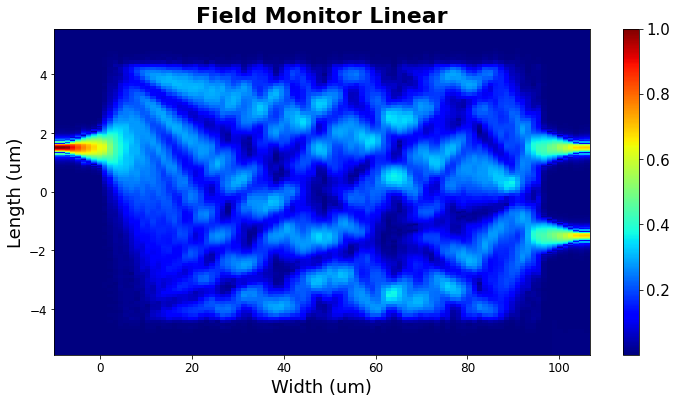

In [5]:
# Plot Linear Field Monitor Graph

lum.emepropagate()

field = lum.getresult('monitor','field profile')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])

plt.figure(figsize=(12, 6), edgecolor= 'white', facecolor= 'white')
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Width (um)',fontsize=18)
plt.ylabel('Length (um)',fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Field Monitor Linear", fontsize = 22, fontweight='bold')
plt.savefig('Field Monitor Linear')


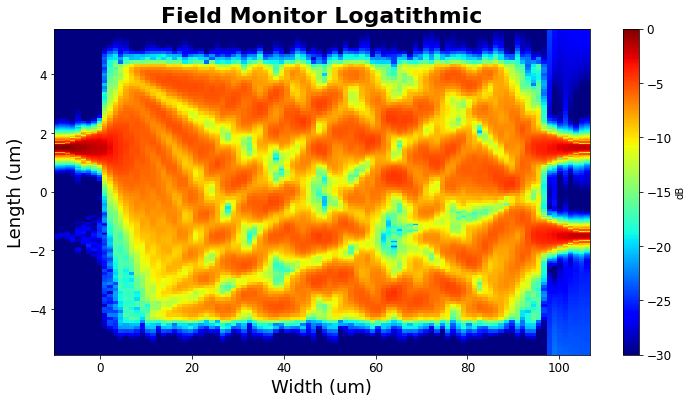

In [6]:
field = lum.getresult('monitor','field profile')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])

#Plot Logarithmic Field Monitor Graph

E = 10*np.log10(E)
plt.figure(figsize=(12, 6), edgecolor= 'white', facecolor= 'white')
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet', vmin = -30)
plt.xlabel('Width (um)',fontsize=18)
plt.ylabel('Length (um)',fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Field Monitor Logatithmic", fontsize = 22, fontweight='bold')
plt.savefig('Field Monitor Logarithmic')

EME Propagation Sweep

/tmp/ipykernel_44181/3393327103.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(span, s31, 'r--', label = 's31', linewidth = '3', color = 'green')


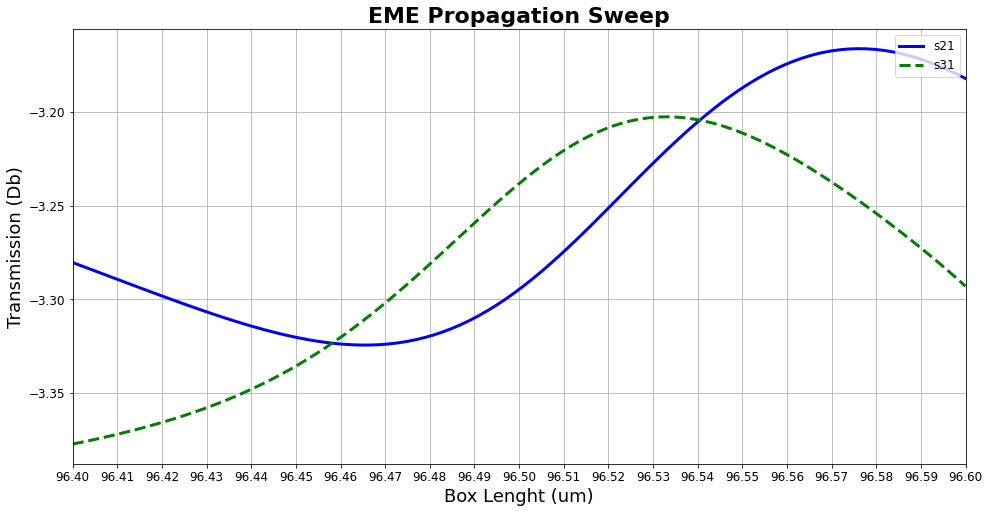

In [8]:
start = 96.4e-6
stop = 96.6e-6

lum.setemeanalysis("Propagation sweep", 1)
lum.setemeanalysis("parameter", "group span 2")
lum.setemeanalysis("start", start)
lum.setemeanalysis("stop", stop)
lum.setemeanalysis("number of points", 100)

lum.emesweep()

S = lum.getemesweep("S")
span = S['group_span_2']*1e6

s21 = 10*lum.log10(abs(S['s21'])**2)
s31 = 10*lum.log10(abs(S['s31'])**2)

plt.figure(figsize=(16, 8), edgecolor= 'white', facecolor= 'white')
plt.plot(span, s21, label = 's21', linewidth = '3', color = 'blue')
plt.plot(span, s31, 'r--', label = 's31', linewidth = '3', color = 'green')
plt.xlim(start*1e6,stop*1e6)
plt.title("EME Propagation Sweep", fontsize = 22, fontweight='bold')
plt.legend(fontsize = 12, loc = "upper right")
plt.xlabel("Box Lenght (um)", fontsize = 18)
plt.xticks(np.arange(start*1e6,stop*1e6,step=0.01),fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Transmission (Db)", fontsize = 18)
plt.grid(True)
plt.savefig('EME Propagation Sweep')

EME Wavelength Sweep

/tmp/ipykernel_44181/3194867930.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(span, s31, 'r--', label = 's31', linewidth = '3', color = 'green')


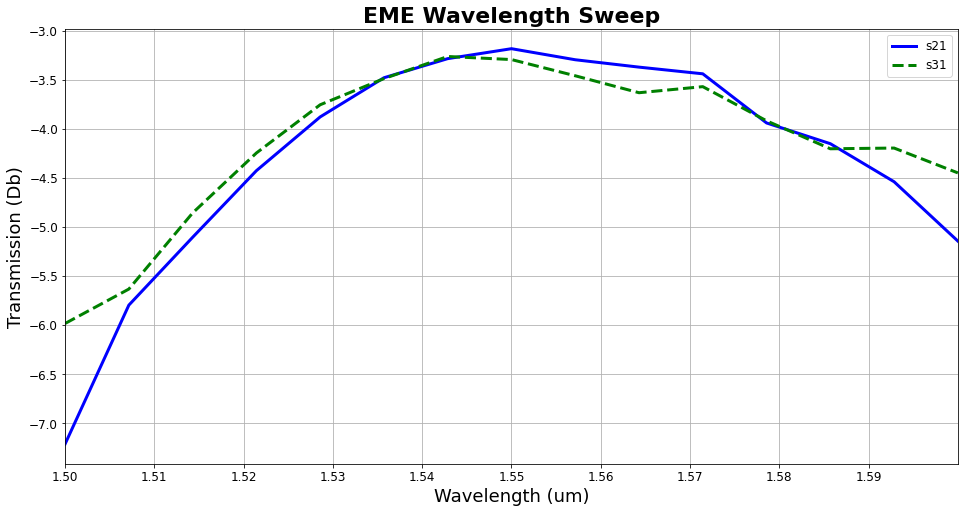

In [9]:
start = 1.5e-6
stop = 1.6e-6

lum.setemeanalysis("wavelength sweep", 1)
lum.setemeanalysis("start wavelength", start)
lum.setemeanalysis("stop wavelength", stop)
lum.setemeanalysis("number of wavelength points", 15)

lum.emesweep("wavelength sweep")

S = lum.getemesweep("S_wavelength_sweep")
span = S['wavelength']*1e6

s21 = 10*lum.log10(abs(S['s21'])**2)
s31 = 10*lum.log10(abs(S['s31'])**2)

plt.figure(figsize=(16, 8), edgecolor= 'white', facecolor= 'white')

plt.plot(span, s21, label = 's21', linewidth = '3', color = 'blue')
plt.plot(span, s31, 'r--', label = 's31', linewidth = '3', color = 'green')
plt.xlim(start*1e6,stop*1e6)
plt.title("EME Wavelength Sweep", fontsize = 22, fontweight='bold')
plt.legend(fontsize = 12, loc = "upper right")
plt.xlabel("Wavelength (um)", fontsize = 18)
plt.xticks(np.arange(start*1e6,stop*1e6,step=0.01),fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Transmission (Db)", fontsize = 18)
plt.grid(True)
plt.savefig('EME Wavelength Sweep')

Export to interconnect

In [10]:
lum.exportemesweep("S_wavelength_sweep.txt")

Export to .gds (Klayout file)

In [11]:
f=lum.gdsopen('MMI_Klayout.gds')
lum.gdsbegincell(f,'MMI')

#lum.addrect(file, layer, xcenter, ycenter, width, height)

#Box
lum.gdsaddrect(f,1,Lpi/2,0,Lpi,W)

#Input Rectangles
x = lum.getnamed("Input Ports::Port_rectangle 1", 'x')
y = lum.getnamed("Input Ports::Port_rectangle 1", 'y')
lum.gdsaddrect(f,1,x,y,portlen,portyspan)
x = lum.getnamed("Input Ports::Port_rectangle 2", 'x')
y = lum.getnamed("Input Ports::Port_rectangle 2", 'y')
lum.gdsaddrect(f,1,x,y,portlen,portyspan)

#Output Rectangles
x = lum.getnamed("Output Ports::Port_rectangle 3", 'x')
y = lum.getnamed("Output Ports::Port_rectangle 3", 'y')
lum.gdsaddrect(f,1,x,y,portlen,portyspan)
x = lum.getnamed("Output Ports::Port_rectangle 4", 'x')
y = lum.getnamed("Output Ports::Port_rectangle 4", 'y')
lum.gdsaddrect(f,1,x,y,portlen,portyspan)

#Input Tappers
x = lum.getnamed("Input Ports::Port 1", 'x')
y = lum.getnamed("Input Ports::Port 1", 'y')
lum.gdsaddpoly(f,1,np.array([[0,y-Wwg/2],[0,y+Wwg/2],[-portlen,y+portyspan/2],[-portlen,y-portyspan/2]]))

x = lum.getnamed("Input Ports::Port 2", 'x')
y = lum.getnamed("Input Ports::Port 2", 'y')
lum.gdsaddpoly(f,1,np.array([[0,y-Wwg/2],[0,y+Wwg/2],[-portlen,y+portyspan/2],[-portlen,y-portyspan/2]]))

#Output Tappers

x = lum.getnamed("Output Ports::Port 3", 'x')
y = lum.getnamed("Output Ports::Port 3", 'y')
lum.gdsaddpoly(f,1,np.array([[Lpi+portlen,y+portyspan/2],[Lpi+portlen,y-portyspan/2],[Lpi,y-Wwg/2],[Lpi,y+Wwg/2]]))

x = lum.getnamed("Output Ports::Port 4", 'x')
y = lum.getnamed("Output Ports::Port 4", 'y')
lum.gdsaddpoly(f,1,np.array([[Lpi+portlen,y+portyspan/2],[Lpi+portlen,y-portyspan/2],[Lpi,y-Wwg/2],[Lpi,y+Wwg/2]]))

lum.gdsendcell(f)
lum.gdsclose(f)

EME Mode Convergence Sweep

/tmp/ipykernel_3877/2317769317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(span, s31, 'r--', label = 's31', linewidth = '3', color = 'green')


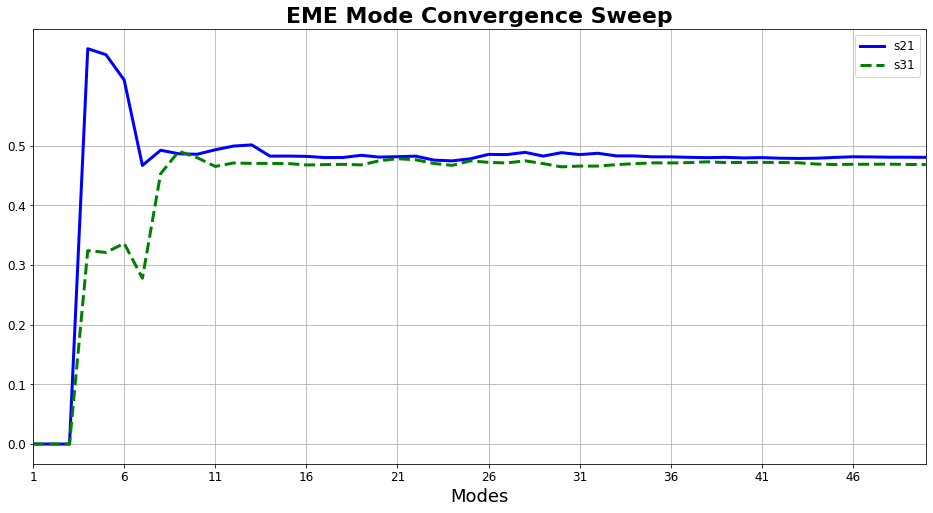

In [65]:
limits = [1,50]
span = np.linspace(limits[0],limits[1],50)
lum.setemeanalysis("mode convergence sweep", 1)

lum.emesweep("mode convergence sweep")

S= lum.getemesweep("S_mode_convergence_sweep")

s21 = np.transpose(abs(S['s21'])**2)
s31 = np.transpose(abs(S['s31'])**2)

plt.figure(figsize=(16, 8), edgecolor= 'white', facecolor= 'white')

plt.plot(span, s21, label = 's21', linewidth = '3', color = 'blue')
plt.plot(span, s31, 'r--', label = 's31', linewidth = '3', color = 'green')
plt.title("EME Mode Convergence Sweep", fontsize = 22, fontweight='bold')
plt.legend(fontsize = 12, loc = "upper right")
plt.xlabel("Modes", fontsize = 18)
plt.xticks(np.arange(limits[0],limits[1],step=5),fontsize=12)
plt.yticks(np.arange(0.0,0.6,step = 0.1),fontsize=12)
plt.xlim(limits[0],limits[1])
plt.grid(True)
plt.savefig('EME Mode Convergence Sweep')

Mesh Convergence Sweep

In [18]:
# Get data

startpoint = 1
points = 20
limits = [3,7]

lum.switchtolayout()
axis = np.linspace(limits[0],limits[1],points)
lum.select("EME")
lum.set("mesh cells y", 100)
lum.set("mesh cells z", 100)
lum.unselectall()

s21 = np.zeros(points)
s31 = np.zeros(points)
dbs21 = np.zeros(points)
dbs31 = np.zeros(points)

for i in range(startpoint-1, points): #Mesh settings
    lum.switchtolayout() 
    for j in range(1,5):
        if(j!=2):
            lum.select("mesh" + str(j))
            lum.set("y mesh multiplier", axis[i])
            lum.set("z mesh multiplier", axis[i])
            lum.unselectall()
    print("Process "+str(i+1)+"/"+str(points) + " in progress...", end = ' ')
    lum.run()
    print(" Done!")
    lum.emepropagate()
    aux = np.array(lum.getresult("EME", "user s matrix"))
    s21[i] = np.abs(aux[1,0]**2)
    s31[i] = np.abs(aux[2,0]**2)
    dbs21[i] = 10*np.log10(s21[i])
    dbs31[i] = 10*np.log10(s31[i])

    pointResults = [[s21[i],s31[i]],
                    [dbs21[i],dbs31[i]]
                    ]

    completeName = os.path.join('Mesh_Sweep_Save','Run '+str(i+1))
    MSOutfile = open(completeName,'wb')
    plk.dump(pointResults,MSOutfile)
    MSOutfile.close()


Process 1/20 in progress...  Done!
Process 2/20 in progress...  Done!
Process 3/20 in progress...  Done!
Process 4/20 in progress...  Done!
Process 5/20 in progress...  Done!
Process 6/20 in progress...  Done!
Process 7/20 in progress...  Done!
Process 8/20 in progress...  Done!
Process 9/20 in progress...  Done!
Process 10/20 in progress...  Done!
Process 11/20 in progress...  Done!
Process 12/20 in progress...  Done!
Process 13/20 in progress...  Done!
Process 14/20 in progress...  Done!
Process 15/20 in progress...  Done!
Process 16/20 in progress...  Done!
Process 17/20 in progress...  Done!
Process 18/20 in progress...  Done!
Process 19/20 in progress...  Done!
Process 20/20 in progress...  Done!


In [19]:
loadPath = 'Mesh_Sweep_Save'
file_count = sum(len(files) for _, _, files in os.walk(loadPath))
data = {}

for i in range(file_count):
    infile = open(os.path.join(loadPath, 'Run '+str(i+1)) , 'rb')
    data['Run '+str(i+1)] = plk.load(infile)
    infile.close()
    
#print(data)
dataFrame = pd.DataFrame(data)
dataFrame

,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,Run 10,Run 11,Run 12,Run 13,Run 14,Run 15,Run 16,Run 17,Run 18,Run 19,Run 20
0,"[0.46444193545954815, 0.4713645360175293]","[0.47804729549678643, 0.4720243701606368]","[0.47617371732219377, 0.4780082346209621]","[0.4701185245397396, 0.45905909539287726]","[0.4634486163656168, 0.46931103457268636]","[0.48081946266561254, 0.46063641799038896]","[0.47893576209233585, 0.4573109228766146]","[0.4758826068205687, 0.46401942661310025]","[0.4811098637060202, 0.4720319574309152]","[0.47615814279461194, 0.4711248790781361]","[0.47535665444054986, 0.4685738882129874]","[0.47535233533051563, 0.46903367743410657]","[0.473796212101137, 0.46410888922774024]","[0.47547606424722455, 0.46843395383132264]","[0.4776340141981588, 0.46912382996407215]","[0.47898645380593674, 0.4669787853067597]","[0.47950229111093473, 0.46482918051246347]","[0.4798556780086184, 0.4627996656080354]","[0.47863815300171186, 0.46099110272874355]","[0.47849304707162454, 0.4600741043647042]"
1,"[-3.3306857378178956, -3.2664309553097954]","[-3.2052913443982445, -3.2603557858399146]","[-3.2223457939932003, -3.205646217568345]","[-3.277926355446084, -3.381314034583236]","[-3.33998410097521, -3.285392344137806]","[-3.18017961227436, -3.3664172962181276]","[-3.1972273301483916, -3.397884253667758]","[-3.2250016807346453, -3.3346383691438586]","[-3.177557391082804, -3.2602859783608817]","[-3.2224878438745685, -3.268639610110677]","[-3.2298042209359408, -3.292219165947516]","[-3.229843681289735, -3.2879597306593764]","[-3.244084156903963, -3.333801133185597]","[-3.228713408232984, -3.293516331830456]","[-3.2090475295791308, -3.2871250574599316]","[-3.1967676867420636, -3.3070284884178465]","[-3.1920931338495633, -3.327066161217055]","[-3.188893619350856, -3.346069635159611]","[-3.199926860449844, -3.363074565476598]","[-3.2012436852530963, -3.371722106561183]"


/tmp/ipykernel_3877/741040792.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  fig[0].plot(axis*100, s31, 'r--', label = 's31', linewidth = '3', color = 'green')
/tmp/ipykernel_3877/741040792.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  fig[1].plot(axis*100, dbs31, 'r--', label = 's31', linewidth = '3', color = 'green')


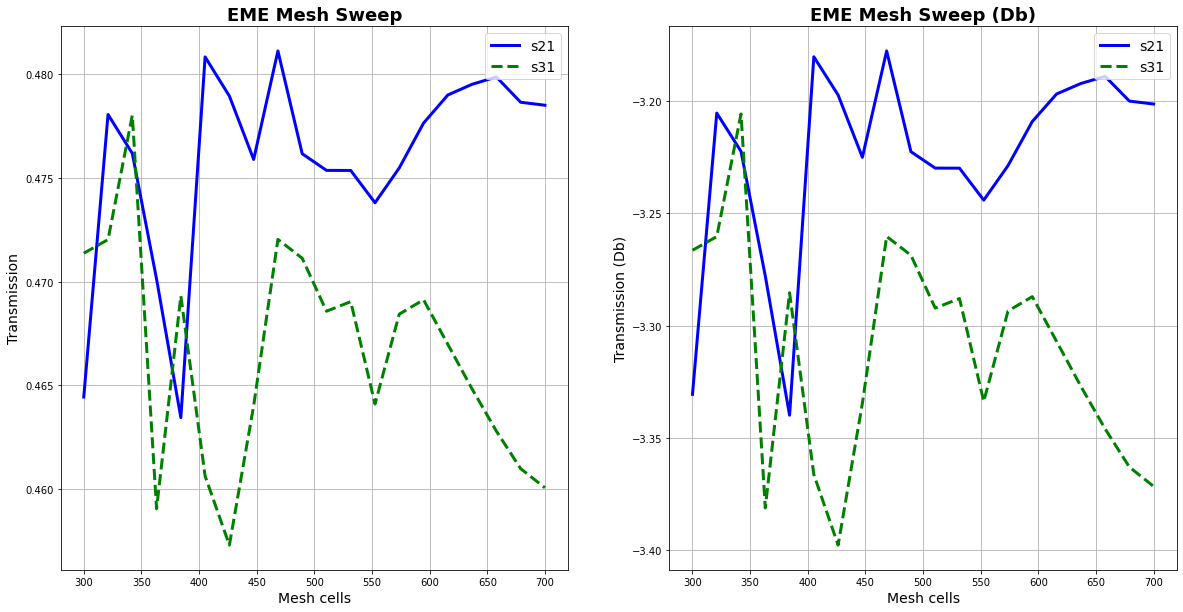

In [22]:
figure1,fig = plt.subplots(1,2, figsize = (20,10)) # Plotting
fig[0].set_title("EME Mesh Sweep", fontsize = 18, fontweight='bold')
fig[0].plot(axis*100, s21, label = 's21', linewidth = '3', color = 'blue')
fig[0].plot(axis*100, s31, 'r--', label = 's31', linewidth = '3', color = 'green')
fig[0].legend(fontsize = 14, loc = "upper right")
fig[0].set_xlabel("Mesh cells", fontsize = 14)
fig[0].set_ylabel("Transmission", fontsize = 14)
fig[0].grid(True)

fig[1].set_title("EME Mesh Sweep (Db)", fontsize = 18, fontweight='bold')
fig[1].plot(axis*100, dbs21, label = 's21', linewidth = '3', color = 'blue')
fig[1].plot(axis*100, dbs31, 'r--', label = 's31', linewidth = '3', color = 'green')
fig[1].legend(fontsize = 14, loc = "upper right")
fig[1].set_xlabel("Mesh cells", fontsize = 14)
fig[1].set_ylabel("Transmission (Db)", fontsize = 14)
fig[1].grid(True)


Temperature Sweep

Process 1/6 in progress...  Done!
Process 2/6 in progress...  Done!
Process 3/6 in progress...  Done!
Process 4/6 in progress...  Done!
Process 5/6 in progress...  Done!
Process 6/6 in progress...  Done!


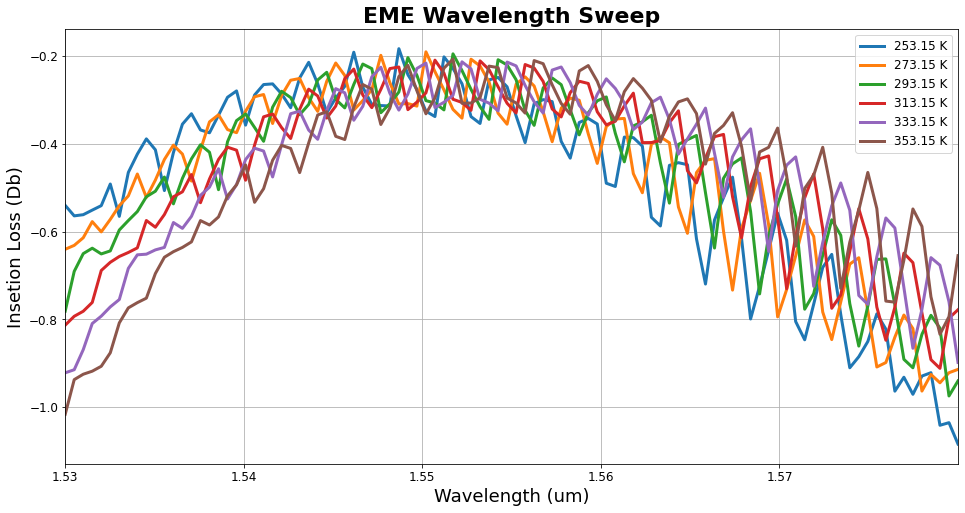

In [10]:
temperature = np.linspace(253.15, 353.15, 6)
plt.figure(figsize=(16,8), edgecolor= 'white', facecolor= 'white')
start = 1.53e-6
stop = 1.58e-6

for i in range(6):
    lum.switchtolayout()
    lum.setnamed('EME', 'simulation temperature', temperature[i])
    print("Process "+str(i+1)+"/"+str(len(temperature)) + " in progress...", end = ' ')
    lum.run()
    print(" Done!")
    lum.setemeanalysis("wavelength sweep", 1)
    lum.setemeanalysis("start wavelength", start)
    lum.setemeanalysis("stop wavelength", stop)
    lum.setemeanalysis("number of wavelength points", 100)
    lum.emesweep("wavelength sweep")

    Sparams = lum.getemesweep("S_wavelength_sweep")
    s21 = (np.abs(Sparams['s21'])**2)
    s31 = (np.abs(Sparams['s31'])**2)
    loss = 10*np.log10(s21 + s31)
    plt.plot(Sparams['wavelength']*1e6, loss, label = str(temperature[i])+ ' K', linewidth = '3')

plt.xlim(start*1e6,stop*1e6)
plt.title("EME Wavelength Sweep", fontsize = 22, fontweight='bold')
plt.legend(fontsize = 12, loc = "upper right")
plt.xlabel("Wavelength (um)", fontsize = 18)
plt.xticks(np.arange(start*1e6,stop*1e6,step=0.01),fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Insetion Loss (Db)", fontsize = 18)
plt.grid(True)
plt.savefig('EME Temperature Sweep')


Save and close

In [12]:
lum.switchtolayout()
lum.save()
lum.close()